In [ ]:
c# STEP 1: Spark Session
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("IrisClassification") \
    .getOrCreate()

# STEP 2: Load the Iris Dataset
import urllib.request

url = "https://raw.githubusercontent.com/uiuc-cse/data-fa14/gh-pages/data/iris.csv"
local_path = "/tmp/iris.csv"
urllib.request.urlretrieve(url, local_path)

df = spark.read.csv(local_path, header=True, inferSchema=True)
print("Sample Data:")
df.show(5)

# STEP 3: Data Preprocessing
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline

label_indexer = StringIndexer(inputCol="species", outputCol="label")
assembler = VectorAssembler(
    inputCols=["sepal_length", "sepal_width", "petal_length", "petal_width"],
    outputCol="features"
)
pipeline = Pipeline(stages=[label_indexer, assembler])
df_prepped = pipeline.fit(df).transform(df)

# STEP 4: Train-Test Split
train_data, test_data = df_prepped.randomSplit([0.8, 0.2], seed=42)

# STEP 5: Train Classification Model
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol="features", labelCol="label")
model = lr.fit(train_data)

# STEP 6: Predict on Test Data
predictions = model.transform(test_data)
print("Predictions Sample:")
predictions.select("features", "label", "prediction", "probability").show(5)

# STEP 7: Model Evaluation
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"\nTest Accuracy: {accuracy:.2f}")

# STEP 8: Predict on New Data (Refined Output)
new_data = spark.createDataFrame([
    (5.1, 3.5, 1.4, 0.2),   # Likely Setosa
    (6.2, 3.4, 5.4, 2.3)    # Likely Virginica
], ["sepal_length", "sepal_width", "petal_length", "petal_width"])

new_prepped = assembler.transform(new_data)
new_predictions = model.transform(new_prepped)

# Convert label index back to species name
from pyspark.ml.feature import IndexToString

label_converter = IndexToString(inputCol="prediction", outputCol="predicted_species",
                                labels=label_indexer.fit(df).labels)
final_predictions = label_converter.transform(new_predictions)

print("\n=== Refined New Data Predictions ===")
final_predictions.select(
    "sepal_length", "sepal_width", "petal_length", "petal_width",
    "predicted_species", "probability"
).show(truncate=False)

# STEP 9: Stop Spark Session
spark.stop()


Sample Data:
+------------+-----------+------------+-----------+-------+
|sepal_length|sepal_width|petal_length|petal_width|species|
+------------+-----------+------------+-----------+-------+
|         5.1|        3.5|         1.4|        0.2| setosa|
|         4.9|        3.0|         1.4|        0.2| setosa|
|         4.7|        3.2|         1.3|        0.2| setosa|
|         4.6|        3.1|         1.5|        0.2| setosa|
|         5.0|        3.6|         1.4|        0.2| setosa|
+------------+-----------+------------+-----------+-------+
only showing top 5 rows

Predictions Sample:
+-----------------+-----+----------+--------------------+
|         features|label|prediction|         probability|
+-----------------+-----+----------+--------------------+
|[4.4,3.0,1.3,0.2]|  0.0|       0.0|[1.0,1.0124194175...|
|[4.6,3.2,1.4,0.2]|  0.0|       0.0|[1.0,1.0111930909...|
|[4.6,3.6,1.0,0.2]|  0.0|       0.0|[1.0,8.1170496280...|
|[4.8,3.1,1.6,0.2]|  0.0|       0.0|[1.0,5.8614722081.

Sample Data:
+------------+-----------+------------+-----------+-------+
|sepal_length|sepal_width|petal_length|petal_width|species|
+------------+-----------+------------+-----------+-------+
|         5.1|        3.5|         1.4|        0.2| setosa|
|         4.9|        3.0|         1.4|        0.2| setosa|
|         4.7|        3.2|         1.3|        0.2| setosa|
|         4.6|        3.1|         1.5|        0.2| setosa|
|         5.0|        3.6|         1.4|        0.2| setosa|
+------------+-----------+------------+-----------+-------+
only showing top 5 rows


=== Cluster Assignments ===
+------------+-----------+------------+-----------+-------+
|sepal_length|sepal_width|petal_length|petal_width|cluster|
+------------+-----------+------------+-----------+-------+
|         5.1|        3.5|         1.4|        0.2|      0|
|         4.9|        3.0|         1.4|        0.2|      0|
|         4.7|        3.2|         1.3|        0.2|      0|
|         4.6|        3.1|       

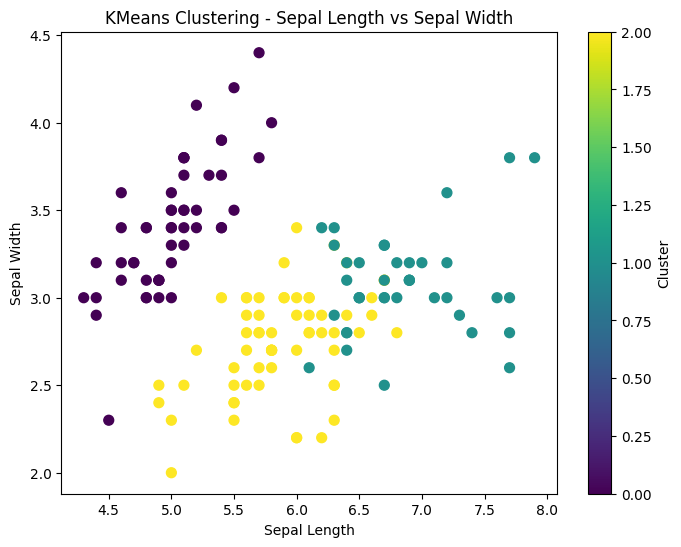

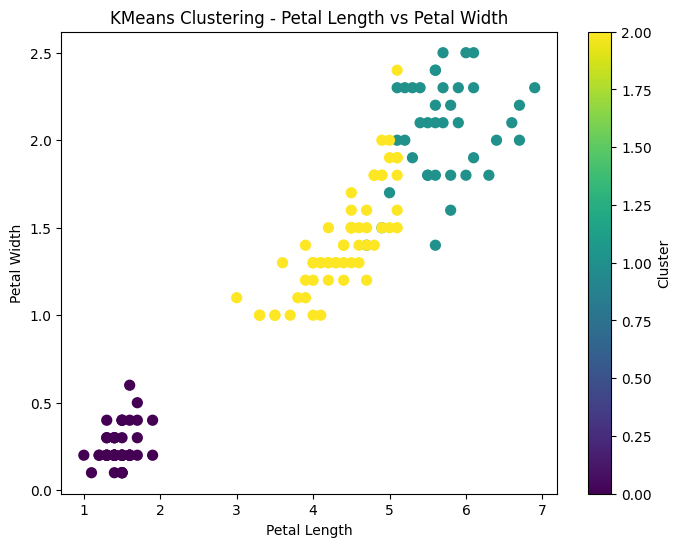

In [ ]:
# STEP 1: Start Spark Session
from pyspark.sql import SparkSession
import urllib.request
import matplotlib.pyplot as plt
import pandas as pd

spark = SparkSession.builder \
    .appName("IrisClustering") \
    .getOrCreate()

# STEP 2: Load Iris Dataset
url = "https://raw.githubusercontent.com/uiuc-cse/data-fa14/gh-pages/data/iris.csv"
local_path = "/tmp/iris.csv"
urllib.request.urlretrieve(url, local_path)

df = spark.read.csv(local_path, header=True, inferSchema=True)
print("Sample Data:")
df.show(5)

# STEP 3: Assemble Features
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=["sepal_length", "sepal_width", "petal_length", "petal_width"],
    outputCol="features"
)
df_features = assembler.transform(df)

# STEP 4: KMeans Clustering
from pyspark.ml.clustering import KMeans

kmeans = KMeans(featuresCol="features", predictionCol="cluster", k=3, seed=42)
model = kmeans.fit(df_features)

# STEP 5: Make Predictions
clustered = model.transform(df_features)

print("\n=== Cluster Assignments ===")
clustered.select("sepal_length", "sepal_width", "petal_length", "petal_width", "cluster").show(10)

# STEP 6: Evaluate Clustering
from pyspark.ml.evaluation import ClusteringEvaluator

evaluator = ClusteringEvaluator(featuresCol="features", predictionCol="cluster", metricName="silhouette")
silhouette = evaluator.evaluate(clustered)

print(f"\nSilhouette Score: {silhouette:.2f}")

# STEP 7: Cluster Centers
centers = model.clusterCenters()
print("\n=== Cluster Centers ===")
for i, center in enumerate(centers):
    print(f"Cluster {i}: {center}")

# STEP 8: Predict Cluster for New Data
new_data = spark.createDataFrame([
    (5.1, 3.5, 1.4, 0.2),
    (6.2, 3.4, 5.4, 2.3)
], ["sepal_length", "sepal_width", "petal_length", "petal_width"])

new_prepped = assembler.transform(new_data)
new_clustered = model.transform(new_prepped)

print("\n=== New Data Cluster Assignments ===")
new_clustered.select("sepal_length", "sepal_width", "petal_length", "petal_width", "cluster").show()

# STEP 9: Visualize Clusters
# Convert to Pandas for plotting
clustered_pd = clustered.select("sepal_length", "sepal_width", "petal_length", "petal_width", "cluster").toPandas()

# Plotting using sepal_length and sepal_width
plt.figure(figsize=(8, 6))
plt.scatter(clustered_pd['sepal_length'], clustered_pd['sepal_width'], c=clustered_pd['cluster'], cmap='viridis', s=50)
plt.title("KMeans Clustering - Sepal Length vs Sepal Width")
plt.xlabel('Sepal Length')
plt.ylabel('Sepal Width')
plt.colorbar(label='Cluster')
plt.show()

# Plotting using petal_length and petal_width
plt.figure(figsize=(8, 6))
plt.scatter(clustered_pd['petal_length'], clustered_pd['petal_width'], c=clustered_pd['cluster'], cmap='viridis', s=50)
plt.title("KMeans Clustering - Petal Length vs Petal Width")
plt.xlabel('Petal Length')
plt.ylabel('Petal Width')
plt.colorbar(label='Cluster')
plt.show()

# STEP 10: Stop Spark Session
spark.stop()


In [1]:
# STEP 1: Start Spark Session
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("MovieRecommendation") \
    .getOrCreate()

# STEP 2: Load MovieLens Dataset
import zipfile
import urllib.request
import os

# URL for the MovieLens dataset
url = "https://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
local_zip_path = "/tmp/ml-latest-small.zip"
local_extract_path = "/tmp/ml-latest-small"

# Download zip file
urllib.request.urlretrieve(url, local_zip_path)

# Extract zip file
with zipfile.ZipFile(local_zip_path, 'r') as zip_ref:
    zip_ref.extractall(local_extract_path)

# Path to ratings.csv file
ratings_path = os.path.join(local_extract_path, "ml-latest-small", "ratings.csv")

# Load the ratings data into a Spark DataFrame
ratings_df = spark.read.csv(ratings_path, header=True, inferSchema=True)
ratings_df.show(5)

# STEP 3: Data Insights
print("Data Insights:")
print(f"Number of users: {ratings_df.select('userId').distinct().count()}")
print(f"Number of movies: {ratings_df.select('movieId').distinct().count()}")
print(f"Total ratings: {ratings_df.count()}")

# Most rated movies
from pyspark.sql.functions import col

movie_ratings = ratings_df.groupBy("movieId").count().orderBy("count", ascending=False)
movie_ratings.show(5)

# STEP 4: Preprocess Data (Drop missing values, etc.)
ratings_df = ratings_df.dropna()

# STEP 5: Build ALS Model for Collaborative Filtering
from pyspark.ml.recommendation import ALS

# Split data into training and testing sets
(training, testing) = ratings_df.randomSplit([0.8, 0.2], seed=42)

# Create the ALS model
als = ALS(userCol="userId", itemCol="movieId", ratingCol="rating", coldStartStrategy="drop", nonnegative=True)
model = als.fit(training)

# STEP 6: Make Predictions on Test Data
predictions = model.transform(testing)
predictions.show(5)

# Evaluate the Model
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print(f"Root-Mean-Square Error (RMSE) on test data: {rmse:.2f}")

# STEP 7: Insights from Recommendations
# Top 5 movie recommendations for each user
user_recommendations = model.recommendForAllUsers(5)
user_recommendations.show(5)

# Display the top 5 movie recommendations for the first user in the dataset
first_user_recommendations = user_recommendations.filter(user_recommendations.userId == 1)
first_user_recommendations.show(5)

# Most popular movies (user-based recommendation)
# Generate top 5 recommendations for all movies
movie_recommendations = model.recommendForAllItems(5)
movie_recommendations.show(5)

# Show recommendations for a specific movie (e.g., movieId = 1)
specific_movie_recommendations = movie_recommendations.filter(movie_recommendations.movieId == 1)
specific_movie_recommendations.show(5)

# STEP 8: Further Insights

# Top 10 users with the most ratings
top_users = ratings_df.groupBy("userId").count().orderBy("count", ascending=False).limit(10)
top_users.show()

# STEP 9: Stop Spark Session
spark.stop()


+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      1|   4.0|964982703|
|     1|      3|   4.0|964981247|
|     1|      6|   4.0|964982224|
|     1|     47|   5.0|964983815|
|     1|     50|   5.0|964982931|
+------+-------+------+---------+
only showing top 5 rows

Data Insights:
Number of users: 610
Number of movies: 9724
Total ratings: 100836
+-------+-----+
|movieId|count|
+-------+-----+
|    356|  329|
|    318|  317|
|    296|  307|
|    593|  279|
|   2571|  278|
+-------+-----+
only showing top 5 rows

+------+-------+------+----------+----------+
|userId|movieId|rating| timestamp|prediction|
+------+-------+------+----------+----------+
|   148|   4896|   4.0|1482548717| 3.4382777|
|   148|   5618|   3.0|1482548682|  3.402998|
|   148|   7153|   3.0|1482548769| 3.4616928|
|   148|  40629|   5.0|1482548578| 3.4400036|
|   148|  40815|   4.0|1482548512| 3.4886706|
+------+-------+------+----------+----------+
only 